# ERA5 Correction via MintPy

#### This notebook utilizes MintPy to apply an ERA5 correction described by Jolivet et al. 2011 to a batch of individual interferograms produced by hyp3. Please see the end of the notebook for a figure that includes an example of a raw interferogram, and ERA5 interferogram, and the interferometric phase change due to the ERA5 correction alone.
Note: This code will only work if in the MintPy source code we comment out lines 808 (ref_y, ref_x = int(atr['REF_Y']), int(atr['REF_X'])) and 817 (data -= data[ref_y, ref_x]). 

In [1]:
import mintpy
from pathlib import Path
from dateutil.parser import parse as parse_date
from pathlib import Path
from typing import List, Union
from osgeo import gdal
from pathlib import Path
from typing import List, Union
import os
import glob
import rasterio
import matplotlib.pyplot as plt
from mintpy.utils import ptime, readfile, writefile, utils as ut

In [7]:
weather_dir = '/mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/'
directories = glob.glob('/mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/S1*/')

In [8]:
for i in directories:
    os.chdir(i)         # Change working Directory
    !pwd
    data_dir = Path.cwd()
    mintpy_config = data_dir / 'mintpy_config.txt'
    mintpy_config.write_text(
    f"""
    mintpy.load.processor        = hyp3
    ##---------interferogram datasets:
    mintpy.load.unwFile          = *_unw_phase.tif
    mintpy.load.corFile          = *_corr.tif
    ##---------geometry datasets:
    mintpy.load.demFile          = *_dem.tif
    mintpy.load.incAngleFile     = *_lv_theta.tif
    mintpy.load.azAngleFile      = *_lv_phi.tif
    mintpy.load.waterMaskFile    = *_water_mask.tif
    """)
    !smallbaselineApp.py --dir {data_dir} {mintpy_config} --dostep load_data
    geom_path = 'inputs/geometryGeo.h5'

    tif_filename = glob.glob('*_unw_phase.tif')[0] #clipped
    unw_filename = f'{tif_filename[:-4]}.unw'

    data, atr = readfile.read(tif_filename, datasetName='phase')
    #atr['OG_FILE_PATH'] = atr['FILE_PATH']
    atr['FILE_TYPE'] = '.unw'
    writefile.write({'phase':data},unw_filename,metadata=atr)
    #!gdal_translate $tif_filename $unw_filename -of ISCE
    #print(unw_filename)
    #!pwd
    #!gdalinfo $unw_filename
    !tropo_pyaps3.py -f $unw_filename -g $geom_path --weather-dir $weather_dir

/mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC
MintPy version v1.3.3, date 2022-04-14
--RUN-at-2022-06-02 17:36:35.018054--
Current directory: /mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: mintpy_config
Go to work directory: /mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC
read custom template file: /mnt/working/eg

In [12]:
unw_corr = '/mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC_unw_phase_ERA5.unw'
igram_corrected=rasterio.open(unw_corr).read(2)

In [13]:
unw = '/mnt/working/egagli/sw/repos/AMATH563-InSAR-denoiser/data-processing/data/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC/S1BB_20210402T152635_20210520T152638_VVP048_INT80_G_weF_28FC_unw_phase.unw'
igram_uncorrected=rasterio.open(unw).read(2)

Text(0.5, 1.0, 'Phase Change from ERA5 Correction')

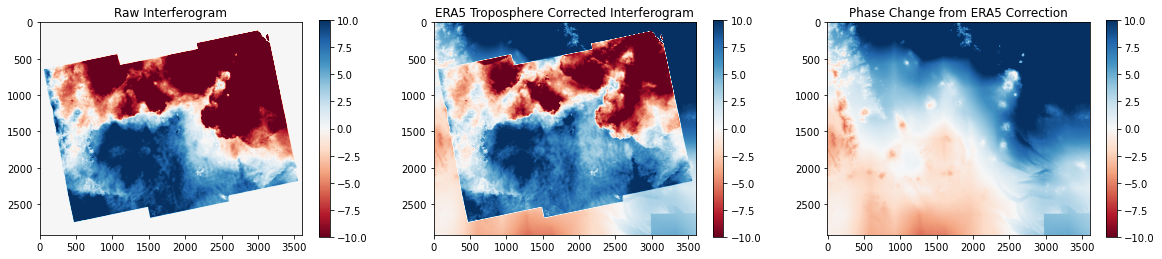

In [19]:
f,ax=plt.subplots(1,3,figsize=(20,4))
l=ax[0].imshow(igram_uncorrected,vmin=-10,vmax=10,cmap='RdBu')
f.colorbar(l,ax=ax[0])
l1=ax[1].imshow(igram_corrected,vmin=-10,vmax=10,cmap='RdBu')
f.colorbar(l1,ax=ax[1])
l2 = ax[2].imshow(igram_corrected-igram_uncorrected,vmin=-10,vmax=10,cmap='RdBu')
f.colorbar(l2,ax=ax[2])
ax[0].set_title('Raw Interferogram')
ax[1].set_title('ERA5 Troposphere Corrected Interferogram')
ax[2].set_title('Phase Change from ERA5 Correction')